## Install Dependencies and Load Datasets

In [1]:
!pip install optuna

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gdown
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import RobustScaler
import optuna
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.inspection import permutation_importance

In [3]:
# Using CSV files with 82k rows
txn_file_id = "1iG3mFohP7A4NqjbVDHV-B917uecBlyz5"
txn_url = f"https://drive.google.com/uc?id={txn_file_id}"
txn_file = gdown.download(txn_url, quiet=False)
txn_df = pd.read_csv(txn_file)
txn_df.head()

Downloading...
From: https://drive.google.com/uc?id=1iG3mFohP7A4NqjbVDHV-B917uecBlyz5
To: C:\Users\User\OneDrive\Documents\BT4012 project\full_df.csv
100%|███████████████████████████████████████████████████████████████████████████████| 29.5M/29.5M [00:01<00:00, 28.2MB/s]


,tx_hash,indegree,outdegree,in_btc,out_btc,total_btc,mean_in_btc,mean_out_btc,in_malicious,out_malicious,...,activity_span_days,cp_hhi_out,cp_hhi_in,peel_len,peel_ratio,pagerank,betweenness_centrality,closeness_centrality,katz_centrality,local_clustering
0,56a96d9841d22764287c9a37cedf97c47678690c2507e0...,5,2,188.74,188.74,377.48,37.748000,94.37,0,0,...,0.000000,10000.0,0.000000,1,3.740000e+08,0.000006,0.0,0.000000,0.001538,0.0
1,93d9e131c856061a11adc1054eaaf7502d147eb9e754fd...,0,1,0.00,50.00,50.00,0.000000,50.00,0,0,...,0.000000,10000.0,0.000000,2,5.000000e+09,0.000006,0.0,0.000000,0.001538,0.0
2,52093f1f0c88f21966817bc6593fcf3e2cb0c314099182...,104,1,5199.00,5199.00,10398.00,49.990385,5199.00,1,0,...,23.596343,10000.0,96.153846,1,1.000000e+00,0.000537,0.0,0.001268,0.017549,0.0
3,31d0381a230ef3c092fac8dd415cb0e02cf4f4546b03de...,0,1,0.00,50.00,50.00,0.000000,50.00,0,0,...,0.000000,10000.0,0.000000,2,5.000000e+09,0.000006,0.0,0.000000,0.001538,0.0
4,ca485d7d88cd8f82730c1530f272edf95e140d66b29f0c...,0,1,0.00,50.00,50.00,0.000000,50.00,0,0,...,0.000000,10000.0,0.000000,2,5.000000e+09,0.000006,0.0,0.000000,0.001538,0.0


## Apply SMOTE on Transactions DataFrame

Approach to SMOTE:
1. Apply stratified splitting of dataset into training and test sets, so that proportion of malicious transactions is about the same as that of normal transactions (80-20)
2. Apply SMOTE to training set

In [4]:
malicious_set = txn_df[txn_df['is_malicious'] == 1]
non_malicious_set = txn_df[txn_df['is_malicious'] == 0]
columns_to_drop = ['tx_hash', 'first_seen', 'last_seen', 'in_malicious', 'out_malicious', 'out_and_tx_malicious', 'all_malicious', 'is_malicious']

X_train_malicious, X_test_malicious, y_train_malicious, y_test_malicious = train_test_split( # 80-20
    malicious_set.drop(columns=columns_to_drop, axis=1, errors='ignore'),
    malicious_set['is_malicious'],
    test_size=0.2,
    random_state=42,
)

X_train_normal, X_test_normal, y_train_normal, y_test_normal = train_test_split( # 80-20
    non_malicious_set.drop(columns=columns_to_drop, axis=1, errors='ignore'),
    non_malicious_set['is_malicious'],
    test_size=0.2,
    random_state=42
)

X_test = pd.concat([X_test_malicious, X_test_normal])
y_test = pd.concat([y_test_malicious, y_test_normal])
X_train = pd.concat([X_train_malicious, X_train_normal])
y_train = pd.concat([y_train_malicious, y_train_normal])

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Value counts before SMOTE:")
print(y_train.value_counts())
print("\nValue counts after SMOTE:")
print(y_train_resampled.value_counts())

Value counts before SMOTE:
is_malicious
0    65574
1       37
Name: count, dtype: int64

Value counts after SMOTE:
is_malicious
1    65574
0    65574
Name: count, dtype: int64


## Feature Engineering

In [5]:
scaler = RobustScaler()

def feature_engineering_train(df):
  df = df.copy()
  features_to_log_scale = ['indegree', 'outdegree', 'in_btc', 'out_btc', 'total_btc', 'mean_in_btc', 'mean_out_btc', 'degree_sum',
                          'degree_diff', 'in_out_degree_ratio', 'in_out_btc_ratio', 'value_per_in_edge', 'value_per_out_edge',
                          'value_per_all_edges', 'tx_count', 'activity_span_seconds', 'activity_span_days', 'peel_len', 'peel_ratio',
                          'pagerank', 'betweenness_centrality', 'closeness_centrality', 'katz_centrality', 'local_clustering']
  features_to_normalize = ['cp_hhi_out', 'cp_hhi_in']

  for col in features_to_log_scale:
    df[col + '_log'] = np.log1p(df[col])

  features_to_normalize.extend([col + '_log' for col in features_to_log_scale])
  df[[c + '_norm' for c in features_to_normalize]] = scaler.fit_transform(df[features_to_normalize])

  df.drop(columns=features_to_normalize + features_to_log_scale, inplace=True)
  return df

def feature_engineering_unseen(df):
  df = df.copy()
  features_to_log_scale = ['indegree', 'outdegree', 'in_btc', 'out_btc', 'total_btc', 'mean_in_btc', 'mean_out_btc', 'degree_sum',
                          'degree_diff', 'in_out_degree_ratio', 'in_out_btc_ratio', 'value_per_in_edge', 'value_per_out_edge',
                          'value_per_all_edges', 'tx_count', 'activity_span_seconds', 'activity_span_days', 'peel_len', 'peel_ratio',
                          'pagerank', 'betweenness_centrality', 'closeness_centrality', 'katz_centrality', 'local_clustering']
  features_to_normalize = ['cp_hhi_out', 'cp_hhi_in']

  for col in features_to_log_scale:
    df[col + '_log'] = np.log1p(df[col])

  features_to_normalize.extend([col + '_log' for col in features_to_log_scale])
  df[[c + '_norm' for c in features_to_normalize]] = scaler.transform(df[features_to_normalize])

  df.drop(columns=features_to_normalize + features_to_log_scale, inplace=True)
  return df

X_train_resampled = feature_engineering_train(X_train_resampled)
X_test = feature_engineering_unseen(X_test)

X_train.head()

,indegree,outdegree,in_btc,out_btc,total_btc,mean_in_btc,mean_out_btc,degree_sum,degree_diff,in_out_degree_ratio,...,activity_span_days,cp_hhi_out,cp_hhi_in,peel_len,peel_ratio,pagerank,betweenness_centrality,closeness_centrality,katz_centrality,local_clustering
18371,34,2,3094.458251,3094.458251,6188.916502,91.013478,1547.229125,36,32,17.0,...,13.384132,5000.0,294.117647,0,0.000000,0.000169,0.000000,0.000416,0.006846,0.004762
16492,7,2,20555.010000,20555.010000,41110.020000,2936.430000,10277.505000,9,5,3.5,...,36.592280,5000.0,1428.571429,0,0.000000,0.001127,0.000009,0.005437,0.004229,0.000000
16923,11,2,3000.010022,3000.010022,6000.020045,272.728184,1500.005011,13,9,5.5,...,4.864190,10000.0,10000.000000,1,0.001114,0.000009,0.000000,0.000012,0.001692,0.000000
51267,43,2,748.018178,748.012178,1496.030355,17.395772,374.006089,45,41,21.5,...,38.735185,5000.0,232.558140,0,0.000000,0.000120,0.000000,0.000851,0.009481,0.000000
36787,1,2,96.028373,96.028373,192.056746,96.028373,48.014187,3,1,0.5,...,0.010914,5000.0,10000.000000,0,0.000000,0.000011,0.000000,0.000012,0.001692,0.000000


## Machine Learning Models
The models that will be trained are:
1. Logistic Regression
2. XGBoost
3. Random Forest
4. LightGBM

### Logistic Regression



In [6]:
def objective_logistic(trial):
    C = trial.suggest_float('C', 0.01, 10.0, log=True)
    solver = trial.suggest_categorical('solver', ['liblinear', 'lbfgs'])

    params = {
        'C': C,
        'solver': solver
    }

    if solver == 'liblinear':
        params['penalty'] = trial.suggest_categorical('penalty_liblinear', ['l1', 'l2'])
        logistic_regression = LogisticRegression(**params, max_iter=20000)
    else:
        params['penalty'] = 'l2'
        logistic_regression = LogisticRegression(**params, max_iter=20000, n_jobs=-1)

    score = cross_val_score(logistic_regression, X_train_resampled, y_train_resampled, cv=5, scoring='roc_auc')
    return score.mean()

study_logistic = optuna.create_study(direction='maximize')
study_logistic.optimize(objective_logistic, n_trials=20)

print("Best hyperparameters found for Logistic Regression:", study_logistic.best_params)
print("Best ROC AUC score found for Logistic Regression:", study_logistic.best_value)

[I 2025-11-22 12:34:02,540] A new study created in memory with name: no-name-fdea1a21-2478-475f-aa51-b0a99ca95048
[I 2025-11-22 12:34:09,499] Trial 0 finished with value: 0.9920514640048497 and parameters: {'C': 0.13064983425202384, 'solver': 'liblinear', 'penalty_liblinear': 'l2'}. Best is trial 0 with value: 0.9920514640048497.
[I 2025-11-22 12:40:27,709] Trial 1 finished with value: 0.9964886036323943 and parameters: {'C': 0.0677423294557978, 'solver': 'lbfgs'}. Best is trial 1 with value: 0.9964886036323943.
[I 2025-11-22 12:40:33,197] Trial 2 finished with value: 0.9919474450725868 and parameters: {'C': 0.21368903478336135, 'solver': 'liblinear', 'penalty_liblinear': 'l2'}. Best is trial 1 with value: 0.9964886036323943.
[I 2025-11-22 12:47:16,042] Trial 3 finished with value: 0.9965929162628436 and parameters: {'C': 0.09210803903314216, 'solver': 'lbfgs'}. Best is trial 3 with value: 0.9965929162628436.
[I 2025-11-22 12:47:21,281] Trial 4 finished with value: 0.9968555854418074 a

Best hyperparameters found for Logistic Regression: {'C': 1.7084858460914343, 'solver': 'liblinear', 'penalty_liblinear': 'l1'}
Best ROC AUC score found for Logistic Regression: 0.9972655180267532


In [7]:
best_params_logistic = study_logistic.best_params

if best_params_logistic['solver'] == 'liblinear':
    best_params_logistic['penalty'] = best_params_logistic.pop('penalty_liblinear')

best_logistic_regression = LogisticRegression(max_iter=20000, **best_params_logistic)
best_logistic_regression.fit(X_train_resampled, y_train_resampled)

y_pred = (best_logistic_regression.predict_proba(X_test)[:, 1] >= 0.5).astype(int)
y_proba = best_logistic_regression.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

print(f"Logistic Regression Accuracy: {accuracy:.4f}")
print(f"Logistic Regression Precision: {precision:.4f}")
print(f"Logistic Regression Recall: {recall:.4f}")
print(f"Logistic Regression F1 Score: {f1:.4f}")
print(f"Logistic Regression ROC AUC: {roc_auc:.4f}")

Logistic Regression Accuracy: 0.9810
Logistic Regression Precision: 0.0252
Logistic Regression Recall: 0.8000
Logistic Regression F1 Score: 0.0488
Logistic Regression ROC AUC: 0.9836


### XGBoost

In [8]:
def objective_xgb(trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0.0, 0.5),
        'lambda': trial.suggest_float('lambda', 0.0, 1.0),
        'alpha': trial.suggest_float('alpha', 0.0, 1.0),
    }

    model = XGBClassifier(**params, random_state=42)
    scores = cross_val_score(model, X_train_resampled, y_train_resampled, cv=5, scoring='roc_auc', n_jobs=-1)
    return scores.mean()

study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=20)

print("\nBest hyperparameters found for XGBoost:", study_xgb.best_params)
print("Best ROC AUC score found for XGBoost:", study_xgb.best_value)

[I 2025-11-22 13:21:38,921] A new study created in memory with name: no-name-2c455bd4-e6b0-4a2c-845c-abb21ac90617
[I 2025-11-22 13:21:52,344] Trial 0 finished with value: 0.9999857169279276 and parameters: {'n_estimators': 475, 'learning_rate': 0.07842759811122735, 'max_depth': 3, 'subsample': 0.5449540385934586, 'colsample_bytree': 0.6328798303448802, 'gamma': 0.35579670490641696, 'lambda': 0.7913928505433314, 'alpha': 0.40114008641342747}. Best is trial 0 with value: 0.9999857169279276.
[I 2025-11-22 13:21:59,386] Trial 1 finished with value: 0.9999931620328514 and parameters: {'n_estimators': 181, 'learning_rate': 0.24564035329423387, 'max_depth': 5, 'subsample': 0.9344732186925773, 'colsample_bytree': 0.7566375358890967, 'gamma': 0.24697541449627214, 'lambda': 0.6258029872859022, 'alpha': 0.739439260925532}. Best is trial 1 with value: 0.9999931620328514.
[I 2025-11-22 13:22:05,208] Trial 2 finished with value: 0.9999867525846993 and parameters: {'n_estimators': 203, 'learning_rate


Best hyperparameters found for XGBoost: {'n_estimators': 181, 'learning_rate': 0.24564035329423387, 'max_depth': 5, 'subsample': 0.9344732186925773, 'colsample_bytree': 0.7566375358890967, 'gamma': 0.24697541449627214, 'lambda': 0.6258029872859022, 'alpha': 0.739439260925532}
Best ROC AUC score found for XGBoost: 0.9999931620328514


In [9]:
best_params_xgb = study_xgb.best_params

best_xgb_model = XGBClassifier(**best_params_xgb, random_state=42)
best_xgb_model.fit(X_train_resampled, y_train_resampled)

y_pred_xgb = (best_xgb_model.predict_proba(X_test)[:, 1] >= 0.5).astype(int)
y_proba_xgb = best_xgb_model.predict_proba(X_test)[:, 1]

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)
roc_auc_xgb = roc_auc_score(y_test, y_proba_xgb)

print(f"XGBoost Accuracy: {accuracy_xgb:.4f}")
print(f"XGBoost Precision: {precision_xgb:.4f}")
print(f"XGBoost Recall: {recall_xgb:.4f}")
print(f"XGBoost F1 Score: {f1_xgb:.4f}")
print(f"XGBoost ROC AUC: {roc_auc_xgb:.4f}")

XGBoost Accuracy: 0.9988
XGBoost Precision: 0.2000
XGBoost Recall: 0.3000
XGBoost F1 Score: 0.2400
XGBoost ROC AUC: 0.8087


### Random Forest

In [17]:
def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
    }

    model = RandomForestClassifier(**params, random_state=42, n_jobs=-1)
    scores = cross_val_score(model, X_train_resampled, y_train_resampled, cv=5, scoring='roc_auc', n_jobs=-1)
    return scores.mean()

study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf, n_trials=20)

print("\nBest hyperparameters found for Random Forest:", study_rf.best_params)
print("Best ROC AUC score found for Random Forest:", study_rf.best_value)

[I 2025-11-22 14:00:55,432] A new study created in memory with name: no-name-ddada9ab-3b68-4b8c-b35b-9f1f0e145a39
[I 2025-11-22 14:07:37,500] Trial 0 finished with value: 0.9999054423655587 and parameters: {'n_estimators': 655, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 6, 'criterion': 'entropy'}. Best is trial 0 with value: 0.9999054423655587.
[I 2025-11-22 14:17:33,799] Trial 1 finished with value: 0.999991430849426 and parameters: {'n_estimators': 763, 'max_depth': 22, 'min_samples_split': 19, 'min_samples_leaf': 3, 'criterion': 'entropy'}. Best is trial 1 with value: 0.999991430849426.
[I 2025-11-22 14:20:14,988] Trial 2 finished with value: 0.999993100445379 and parameters: {'n_estimators': 196, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'entropy'}. Best is trial 2 with value: 0.999993100445379.
[I 2025-11-22 14:27:26,553] Trial 3 finished with value: 0.9998880827616219 and parameters: {'n_estimators': 810, 'max_depth': 9, 'min_sa


Best hyperparameters found for Random Forest: {'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 15, 'min_samples_leaf': 1, 'criterion': 'entropy'}
Best ROC AUC score found for Random Forest: 0.9999940173726202


In [18]:
best_params_rf = study_rf.best_params

best_rf_model = RandomForestClassifier(**best_params_rf, random_state=42, n_jobs=-1)
best_rf_model.fit(X_train_resampled, y_train_resampled)

y_pred_rf = (best_rf_model.predict_proba(X_test)[:, 1] >= 0.5).astype(int)
y_proba_rf = best_rf_model.predict_proba(X_test)[:, 1]

accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, y_proba_rf)

print(f"Random Forest Accuracy: {accuracy_rf:.4f}")
print(f"Random Forest Precision: {precision_rf:.4f}")
print(f"Random Forest Recall: {recall_rf:.4f}")
print(f"Random Forest F1 Score: {f1_rf:.4f}")
print(f"Random Forest ROC AUC: {roc_auc_rf:.4f}")

Random Forest Accuracy: 0.9985
Random Forest Precision: 0.1053
Random Forest Recall: 0.2000
Random Forest F1 Score: 0.1379
Random Forest ROC AUC: 0.7384


### LightGBM

In [11]:
def objective_lgb(trial):
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 15, 255),
        'max_depth': trial.suggest_int('max_depth', -1, 16),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),

        'objective': 'binary',
        'random_state': 42,
        'n_jobs': -1,
        'verbosity': -1
    }

    model = lgb.LGBMClassifier(**params)
    scores = cross_val_score(model, X_train_resampled, y_train_resampled, cv=5, scoring='roc_auc', n_jobs=-1)
    return scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective_lgb, n_trials=20)

print("Best hyperparameters found for LightGBM:", study.best_params)
print("Best ROC-AUC score found for LightGBM:", study.best_value)

[I 2025-11-22 13:48:25,085] A new study created in memory with name: no-name-0d228933-3141-48b5-b6ea-5d05635f5f50
[I 2025-11-22 13:49:18,191] Trial 0 finished with value: 0.999991796559839 and parameters: {'num_leaves': 75, 'max_depth': -1, 'learning_rate': 0.0319283719772611, 'n_estimators': 433, 'min_child_samples': 61, 'subsample': 0.6306413444525042, 'colsample_bytree': 0.9121082672209218, 'reg_alpha': 0.0030411152314544017, 'reg_lambda': 8.494646751653575e-07}. Best is trial 0 with value: 0.999991796559839.
[I 2025-11-22 13:49:44,647] Trial 1 finished with value: 0.9999885996336915 and parameters: {'num_leaves': 76, 'max_depth': 3, 'learning_rate': 0.1307008675524886, 'n_estimators': 587, 'min_child_samples': 5, 'subsample': 0.8289089037285182, 'colsample_bytree': 0.7907065318552176, 'reg_alpha': 0.028146144746293397, 'reg_lambda': 0.010929245386857788}. Best is trial 0 with value: 0.999991796559839.
[I 2025-11-22 13:49:57,939] Trial 2 finished with value: 0.9998822285306079 and p

Best hyperparameters found for LightGBM: {'num_leaves': 18, 'max_depth': 10, 'learning_rate': 0.1206835424424935, 'n_estimators': 411, 'min_child_samples': 66, 'subsample': 0.8710668044821345, 'colsample_bytree': 0.8848467126577785, 'reg_alpha': 3.230367413319988, 'reg_lambda': 2.626380228755494e-08}
Best ROC-AUC score found for LightGBM: 0.9999932638646827


In [12]:
# Make predictions on test set using best LightGBM model
best_params = study.best_params

best_params.update({
    'objective': 'binary',
    'random_state': 42,
    'n_jobs': -1,
    'verbosity': -1
})

best_lgbm = lgb.LGBMClassifier(**best_params)
best_lgbm.fit(X_train_resampled, y_train_resampled)

# Probabilities and class predictions
y_proba_lgb = best_lgbm.predict_proba(X_test)[:, 1]
y_pred_lgb = (y_proba_lgb >= 0.5).astype(int)

accuracy_lgb = accuracy_score(y_test, y_pred_lgb)
precision_lgb = precision_score(y_test, y_pred_lgb, zero_division=0)
recall_lgb = recall_score(y_test, y_pred_lgb, zero_division=0)
f1_lgb = f1_score(y_test, y_pred_lgb, zero_division=0)
roc_auc_lgb = roc_auc_score(y_test, y_proba_lgb)

print(f"LightGBM Accuracy: {accuracy_lgb:.4f}")
print(f"LightGBM Precision: {precision_lgb:.4f}")
print(f"LightGBM Recall: {recall_lgb:.4f}")
print(f"LightGBM F1 Score: {f1_lgb:.4f}")
print(f"LightGBM ROC AUC: {roc_auc_lgb:.4f}")

LightGBM Accuracy: 0.9985
LightGBM Precision: 0.1111
LightGBM Recall: 0.2000
LightGBM F1 Score: 0.1429
LightGBM ROC AUC: 0.6473


## Feature Importance for Tabular Models

In [13]:
X_test_importance = X_test.copy()
y_test_importance = y_test.copy()

### Logistic Regression

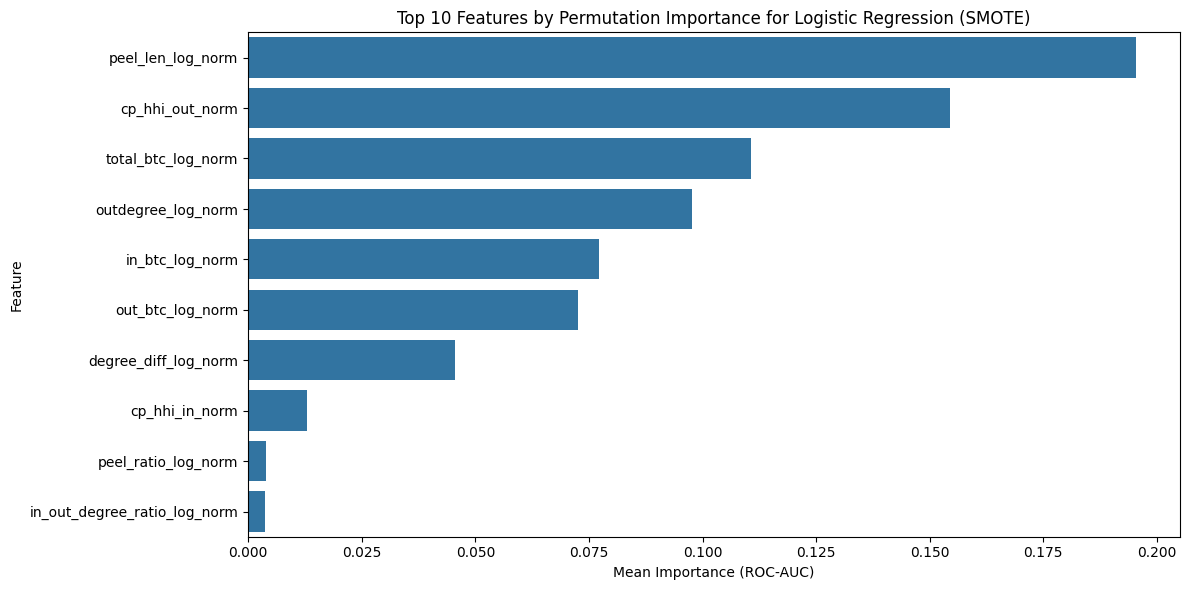

In [14]:
result = permutation_importance(
    best_logistic_regression,
    X_test_importance,
    y_test_importance,
    scoring='roc_auc',
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

feature_importances = pd.DataFrame({
    'feature': X_test_importance.columns,
    'importance_mean': result.importances_mean,
    'importance_std': result.importances_std
})

# Sort by importance and display top 10
feature_importances = feature_importances.sort_values(by='importance_mean', ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x='importance_mean', y='feature', data=feature_importances.head(10))
plt.title('Top 10 Features by Permutation Importance for Logistic Regression (SMOTE)')
plt.xlabel('Mean Importance (ROC-AUC)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

### XGBoost

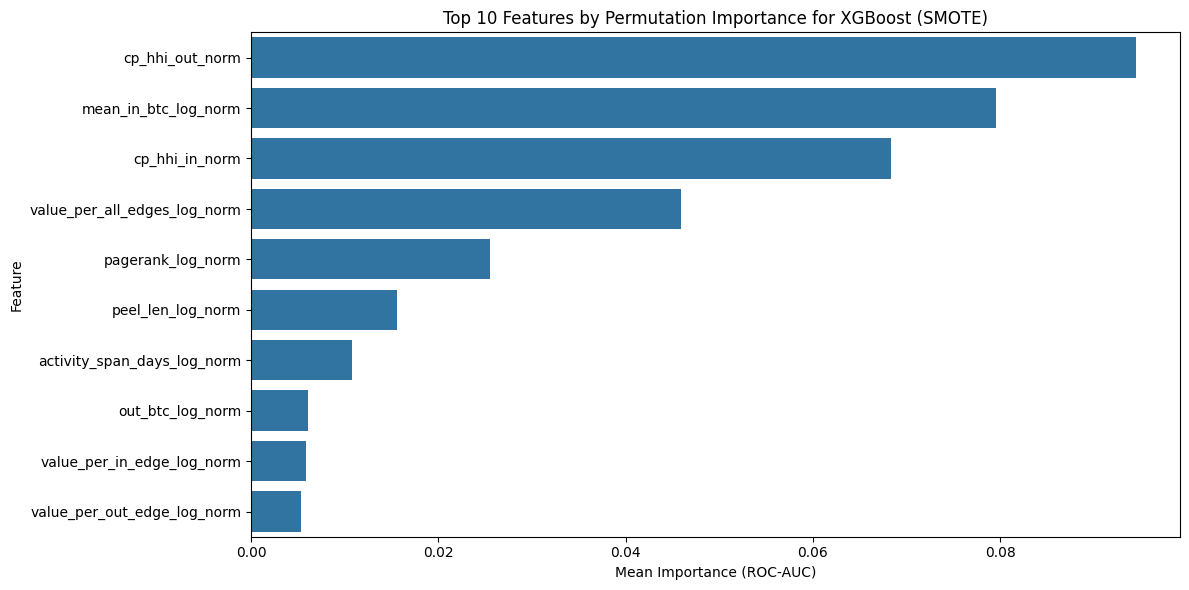

In [15]:
result = permutation_importance(
    best_xgb_model,
    X_test_importance,
    y_test_importance,
    scoring='roc_auc',
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

feature_importances = pd.DataFrame({
    'feature': X_test_importance.columns,
    'importance_mean': result.importances_mean,
    'importance_std': result.importances_std
})

# Sort by importance and display top 10
feature_importances = feature_importances.sort_values(by='importance_mean', ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x='importance_mean', y='feature', data=feature_importances.head(10))
plt.title('Top 10 Features by Permutation Importance for XGBoost (SMOTE)')
plt.xlabel('Mean Importance (ROC-AUC)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

### Random Forest

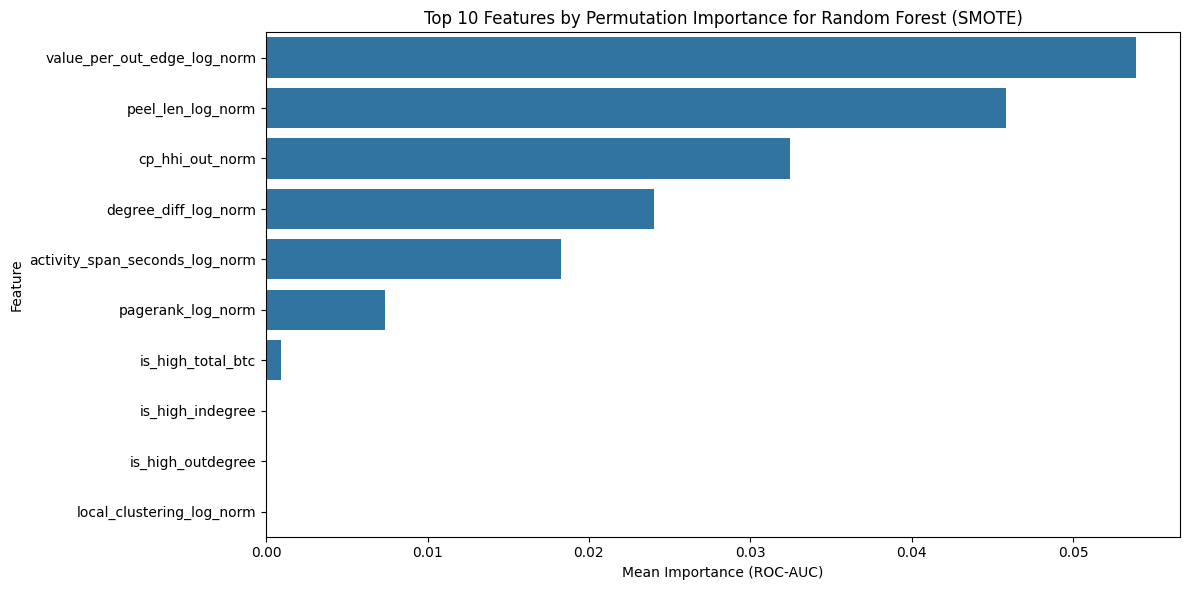

In [19]:
result = permutation_importance(
    best_rf_model,
    X_test_importance,
    y_test_importance,
    scoring='roc_auc',
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

feature_importances = pd.DataFrame({
    'feature': X_test_importance.columns,
    'importance_mean': result.importances_mean,
    'importance_std': result.importances_std
})

# Sort by importance and display top 10
feature_importances = feature_importances.sort_values(by='importance_mean', ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x='importance_mean', y='feature', data=feature_importances.head(10))
plt.title('Top 10 Features by Permutation Importance for Random Forest (SMOTE)')
plt.xlabel('Mean Importance (ROC-AUC)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

### LightGBM

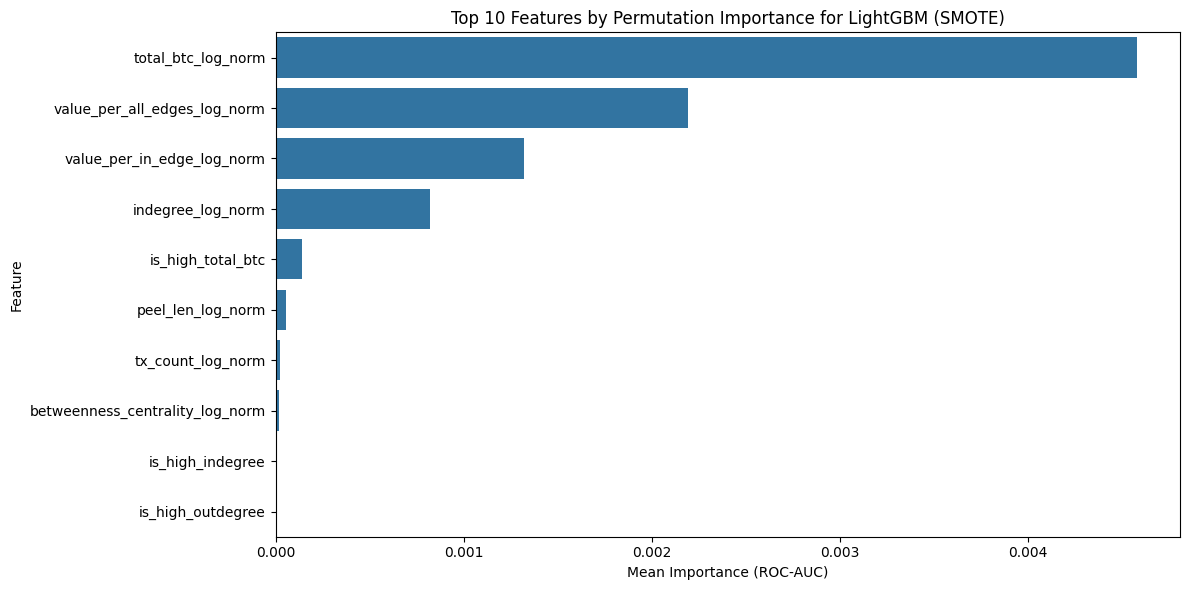

In [16]:
result = permutation_importance(
    best_lgbm,
    X_test_importance,
    y_test_importance,
    scoring='roc_auc',
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

feature_importances = pd.DataFrame({
    'feature': X_test_importance.columns,
    'importance_mean': result.importances_mean,
    'importance_std': result.importances_std
})

# Sort by importance and display top 10
feature_importances = feature_importances.sort_values(by='importance_mean', ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x='importance_mean', y='feature', data=feature_importances.head(10))
plt.title('Top 10 Features by Permutation Importance for LightGBM (SMOTE)')
plt.xlabel('Mean Importance (ROC-AUC)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()